<a href="https://colab.research.google.com/github/s-choung/Simulation_tutorials/blob/main/handson4_dft_adsorption_application.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Get GPAW as we did last session
- GPAW(+dependencies+ASE)
- POVRAY

Hit:1 http://archive.ubuntu.com/ubuntu jammy InRelease
Get:2 http://archive.ubuntu.com/ubuntu jammy-updates InRelease [128 kB]
Get:3 http://archive.ubuntu.com/ubuntu jammy-backports InRelease [127 kB]
Get:4 http://security.ubuntu.com/ubuntu jammy-security InRelease [129 kB]
Get:5 https://cloud.r-project.org/bin/linux/ubuntu jammy-cran40/ InRelease [3,626 B]
Ign:6 https://r2u.stat.illinois.edu/ubuntu jammy InRelease
Get:7 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu2204/x86_64  InRelease [1,581 B]
Get:8 https://r2u.stat.illinois.edu/ubuntu jammy Release [5,713 B]
Get:9 https://r2u.stat.illinois.edu/ubuntu jammy Release.gpg [793 B]
Hit:10 https://ppa.launchpadcontent.net/deadsnakes/ppa/ubuntu jammy InRelease
Get:11 https://ppa.launchpadcontent.net/graphics-drivers/ppa/ubuntu jammy InRelease [24.3 kB]
Hit:12 https://ppa.launchpadcontent.net/ubuntugis/ppa/ubuntu jammy InRelease
Get:13 http://archive.ubuntu.com/ubuntu jammy-updates/main amd64 Packages [2,596 kB]
Get:14 ht

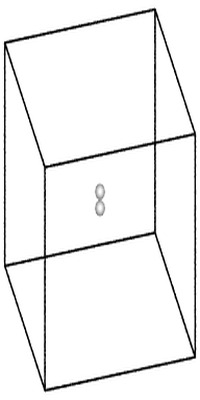

In [ ]:
!apt-get update
!apt-get install -y python3-dev libopenblas-dev liblapack-dev libfftw3-dev libxc-dev
!pip install gpaw
!gpaw test
!wget https://wiki.fysik.dtu.dk/gpaw-files/gpaw-setups-24.1.0.tar.gz
!tar -xzf gpaw-setups-24.1.0.tar.gz

import os
import gzip
import shutil

# Define the path to the setup files
setup_path = '/content/gpaw-setups-24.1.0'

# Uncompress all .gz files in the setup directory
for filename in os.listdir(setup_path):
    if filename.endswith('.gz'):
        filepath = os.path.join(setup_path, filename)
        with gzip.open(filepath, 'rb') as f_in:
            with open(filepath[:-3], 'wb') as f_out:
                shutil.copyfileobj(f_in, f_out)

# Set the GPAW_SETUP_PATH environment variable
os.environ['GPAW_SETUP_PATH'] = setup_path
# Verify the environment variable
print("GPAW_SETUP_PATH:", os.environ['GPAW_SETUP_PATH'])

# Import ASE and GPAW and run your calculation
from ase import Atoms
from gpaw import GPAW

# Define the atomic structure
d = 0.74
a = 10.0

h2 = Atoms('H2',
              positions=[(0, 0, 0),
                         (0, 0, d)],
              cell=(a, a, a))
h2.center()
# Initialize GPAW calculator without specifying the 'setups' parameter
calc = GPAW(mode='fd', nbands=2, txt='h2.txt')
h2.calc = calc

# Run the calculation
print("Forces on atoms:", h2.get_forces())
print("Energies on atoms:", h2.get_total_energy())

!sudo apt-get install povray  ## visulization program

import shutil
from ase.io import write  # Import the write function from ASE
from PIL import Image
from IPython.display import display  # Import display for Jupyter Notebooks


def visual(structure, max_size=(200, 200), stretch_y=2.0, rotation='15z,-60x', png_save_path='./'):
    renderer = write('./temp.pov', structure, rotation=rotation)
    renderer.render()
    image_path = './temp.png'
    img = Image.open(image_path)

    # Calculate new size with stretch factor
    new_size = (max_size[0], int(max_size[1] * stretch_y))
    img = img.resize(new_size, Image.LANCZOS)
    display(img)

    # Move files to output directory
    files = ['./temp.ini', './temp.pov', './temp.png']
    destination = './output/'

    # Ensure destination directory exists
    os.makedirs(destination, exist_ok=True)

    for file in files:
        # Remove the file in the destination directory if it exists
        if os.path.isfile(os.path.join(destination, os.path.basename(file))):
            os.remove(os.path.join(destination, os.path.basename(file)))

        if file == './temp.png':
            new_file_name = png_save_path + f'temp.png'
        else:
            new_file_name = os.path.basename(file)
        shutil.move(file, os.path.join(destination, new_file_name))
visual(h2)

## Lets make a catalyst surface using ase.build library

Type all the calculation setups defined in last hands-on session

Atomic numbers: [78 78 78 78]
Chemical symbols: ['Pt', 'Pt', 'Pt', 'Pt']
Positions: [[0.00000000e+00 0.00000000e+00 7.50000000e+00]
 [1.38946483e+00 8.02207891e-01 9.76898656e+00]
 [2.25943403e-17 1.60441578e+00 1.20379731e+01]
 [0.00000000e+00 0.00000000e+00 1.43069597e+01]]
Potential Energy: -22.90267349329772 eV
Time taken: 69.51 seconds
Atoms(symbols='Pt4', pbc=[True, True, False], cell=[[2.778929650063132, 0.0, 0.0], [1.389464825031566, 2.4066236722844723, 0.0], [0.0, 0.0, 21.806959673745688]], tags=..., constraint=FixAtoms(indices=[0, 1]), calculator=GPAW(...))


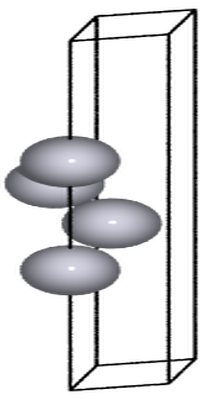

In [ ]:
"""Bulk Pt(fcc) test"""
from ase import Atoms
from ase.visualize import view
from gpaw import GPAW, PW
from ase.build import bulk
import time
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from ase.build import fcc111
from ase.constraints import FixAtoms

name = 'Pt-fcc'
a0 = 3.93  # fcc lattice parameter
k = 4
element='Pt'

"""Surface Pt(fcc) test"""


# Initialize the parameters
N_layer = 4 # number of layers
size = 1 #  supercell size
vac = 7.5

surf = fcc111(element, (size, size, N_layer), a=a0, vacuum=vac)

median_z = np.median(surf.positions[:, 2])
constraint = FixAtoms(mask=[atom.position[2] < (median_z + 0.01) for atom in surf])
surf.set_constraint(constraint)

# Set up the GPAW calculator
calc = GPAW(mode=PW(400),
            kpts=(k, k, 1),
            xc='PBE',
            txt='slab.txt')
# Attach the calculator to the slab
surf.calc = calc

start_time = time.time()
E_slab = surf.get_potential_energy()
end_time = time.time()

# Calculate the elapsed time
elapsed_time = end_time - start_time
print("Atomic numbers:", surf.get_atomic_numbers())
print("Chemical symbols:", surf.get_chemical_symbols())
print("Positions:", surf.get_positions())
# Print the energy and the elapsed time
print(f'Potential Energy: {e} eV')
print(f'Time taken: {elapsed_time:.2f} seconds')
print(surf)
visual(surf)


In [ ]:
def enlarge_and_visual(atoms,angle='15z,-60x'):
  temp=atoms.copy()
  temp=temp*(3,3,1)
  temp.cell=atoms.cell
  visual(temp, rotation=angle)

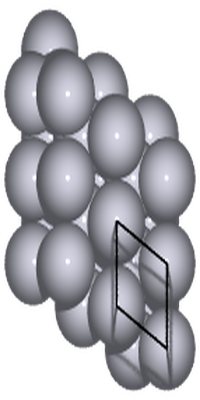

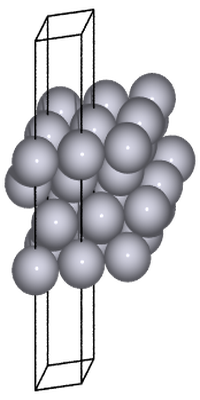

In [ ]:
enlarge_and_visual(surf,angle='90z,-0x')
enlarge_and_visual(surf,angle='15z,-60x')

# Adsorption energy of CO and O on Pt(111) surface

## 1. CO adsorption


Atoms(symbols='Pt4', pbc=[True, True, False], cell=[[2.778929650063132, 0.0, 0.0], [1.389464825031566, 2.4066236722844723, 0.0], [0.0, 0.0, 21.806959673745688]], tags=..., constraint=FixAtoms(indices=[0, 1]))
Atoms(symbols='Pt4CO', pbc=[True, True, False], cell=[[2.778929650063132, 0.0, 0.0], [1.389464825031566, 2.4066236722844723, 0.0], [0.0, 0.0, 21.806959673745688]], tags=..., constraint=FixAtoms(indices=[0, 1]))


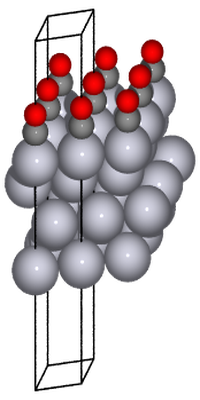

Adsorption energy: -0.64


In [ ]:
import time
import numpy as np
from ase.build import fcc100
from ase.constraints import FixAtoms
from gpaw import GPAW, PW
from ase.build import add_adsorbate

CO = Atoms('CO',
              positions=[(0, 0, 0),
                         (0, 0, 1.1)],
              cell=(a, a, a),pbc='TRUE')

CO.calc = calc
adslab=surf.copy()
print(adslab)
add_adsorbate(adslab, CO, 1.8, 'ontop') #     Supported  adsorption sites: 'ontop', 'bridge', 'fcc' and 'hcp'. (https://gitlab.com/ase/ase/-/blob/master/ase/build/surface.py)
print(adslab)
enlarge_and_visual(adslab)
adslab.calc = calc

E_adslab = adslab.get_potential_energy()
E_CO = CO.get_potential_energy()
E_ads= E_adslab - E_CO - E_slab
print('Adsorption energy:', round(E_ads,2))

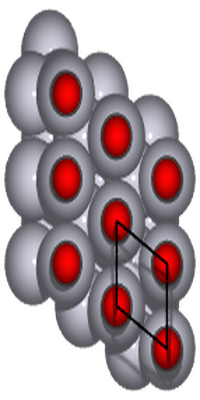

In [ ]:
enlarge_and_visual(adslab,angle='90z,-0x')

1.2 Adsorption of O

Atoms(symbols='Pt4', pbc=[True, True, False], cell=[[2.778929650063132, 0.0, 0.0], [1.389464825031566, 2.4066236722844723, 0.0], [0.0, 0.0, 21.806959673745688]], tags=..., constraint=FixAtoms(indices=[0, 1]))
Atoms(symbols='Pt4O', pbc=[True, True, False], cell=[[2.778929650063132, 0.0, 0.0], [1.389464825031566, 2.4066236722844723, 0.0], [0.0, 0.0, 21.806959673745688]], tags=..., constraint=FixAtoms(indices=[0, 1]))


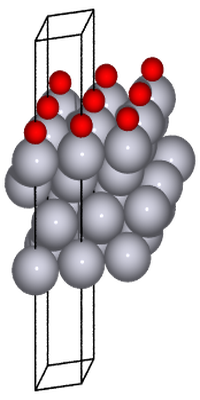

Adsorption energy: -0.6498267263463369


In [ ]:
O2 = Atoms('O2',
              positions=[(0, 0, 0),
                         (0, 0, 1.1)],
              cell=(a, a, a),pbc='TRUE')

O2.calc = calc
adsorbate_atom=Atoms('O')
adslab=surf.copy()
print(adslab)
add_adsorbate(adslab, adsorbate_atom, 1.8, 'ontop') #     Supported  adsorption sites: 'ontop', 'bridge', 'fcc' and 'hcp'. (https://gitlab.com/ase/ase/-/blob/master/ase/build/surface.py)
print(adslab)
enlarge_and_visual(adslab)
adslab.calc = calc

E_adslab = adslab.get_potential_energy()
E_O2 = O2.get_potential_energy()
E_ads= E_adslab - E_O2/2 - E_slab
print('Adsorption energy:', E_ads)

## 2. test Adsorption sites

<<<<ontop>>>>


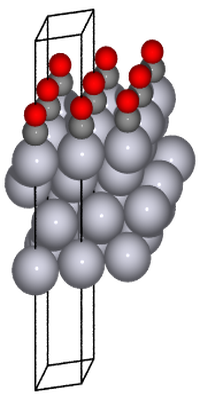

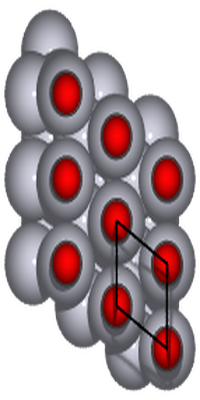

In [ ]:

for site in ['ontop', 'bridge', 'fcc', 'hcp']:
    start_time = time.time()  # Start timing
    adslab = surf.copy()
    add_adsorbate(adslab, CO, 1.8, site)
    print(f'<<<<{site}>>>>')
    enlarge_and_visual(adslab)
    enlarge_and_visual(adslab,angle='90z,-0x') # topview
    # Set the calculator
    adslab.calc = calc
    # Calculate energies
    E_adslab = adslab.get_potential_energy()
    E_CO = CO.get_potential_energy()
    E_ads = E_adslab - E_CO - E_slab
    # Calculate the elapsed time
    elapsed_time = time.time() - start_time
    # Print results
    print(f'Adsorption site: {site}')
    print(f'Adsorption energy: {round(E_ads, 2)} eV')
    print(f'Time taken: {elapsed_time:.2f} seconds\n')


## 3. test Adsorption coverage 1ML, 1/4ML ((Optional) and 1/9ML)

<<<<coverage=1ML>>>>


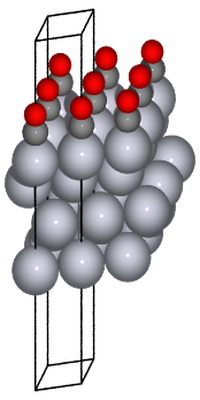

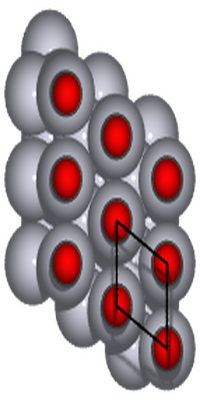

Adsorption site: hcp
Adsorption energy: -0.64 eV
Time taken: 104.54 seconds

<<<<coverage=1/4ML>>>>


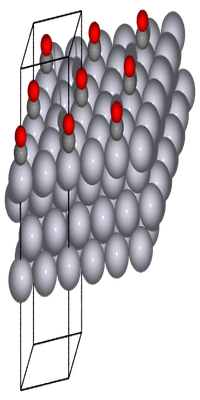

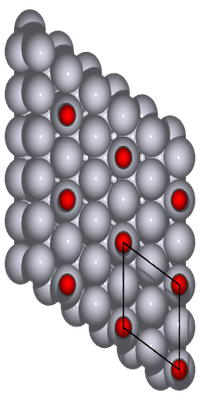

Adsorption site: hcp
Adsorption energy: -2.55 eV
Time taken: 1511.63 seconds



In [ ]:
from fractions import Fraction

for size in [1,2]:#,3]:
    coverage = Fraction(1, size*size)
    print(f'<<<<coverage={coverage}ML>>>>')
    start_time = time.time()  # Start timing
    adslab = surf.copy()
    adslab=adslab * (size,size,1) ## BECAREFUL YOUR CALCULATION COULD BE EXTREAMELY HEAVY for size 3 or more
    add_adsorbate(adslab, CO, 1.8, 'ontop')
    enlarge_and_visual(adslab)
    enlarge_and_visual(adslab,angle='90z,-0x') # topview
    k=4 # set k=1 for test
    calc = GPAW(mode=PW(400), # recommend to use at least 400 for cutoff but calculation is going to be very heavy
                kpts=(k, k, 1), # you can change k points in regards to the size of cell.
                xc='PBE',
                txt='slab.txt')
    # Set the calculator
    adslab.calc = calc
    # Calculate energies
    E_adslab = adslab.get_potential_energy() # turn this code line off for test first.
    E_ads = E_adslab - E_CO - E_slab * size * size # let me simply multiply the E_slab with size.
    # Calculate the elapsed time
    elapsed_time = time.time() - start_time
    # Print results
    print(f'Adsorption energy: {round(E_ads, 2)} eV')
    print(f'Time taken: {elapsed_time:.2f} seconds\n')


## (Optional)Test adsorption strength on different surface facets (fcc100, fcc110, fcc111) #

    supported adsorption sites of fcc(100) 'ontop', 'bridge', 'hollow'
   
    supported adsorption sites of fcc(110) 'ontop', 'longbridge',
    'shortbridge', 'hollow'

https://gitlab.com/ase/ase/-/blob/master/ase/build/surface.py


modify code below.

```
import time
import numpy as np
from ase.build import fcc100, fcc110, fcc111
from ase.constraints import FixAtoms
from gpaw import GPAW, PW

# Parameters
a0 = 4  # lattice constant
k = 4   # KPOINTS
N_layer = 4  # number of layers
size = 1  # supercell size
vac = 7.5  # vacuum size

# List of FCC surfaces to test
fcc_surfaces = [('fcc100', fcc100), ('fcc110', fcc110), ('fcc111', fcc111)]

# Iterate over different FCC orientations
for surface_name, surface_function in fcc_surfaces:
    surf = surface_function('Al', (size, size, N_layer), a=a0, vacuum=vac)
    # Calculate the median z-position
    median_z = np.median(surf.positions[:, 2])

    # Apply constraint to fix bottom half of the slab
    constraint = FixAtoms(mask=[atom.position[2] < (median_z + 0.01) for atom in surf])
    surf.set_constraint(constraint)

    # Set up the GPAW calculator
    calc = GPAW(mode=PW(300),
                kpts=(k, k, 1),
                xc='PBE',
                txt=f'{surface_name}_slab.txt')
    surf.calc = calc

    # Start timing
    start_time = time.time()

    # Run the calculation to get the potential energy
    e = surf.get_potential_energy()

    # End timing
    elapsed_time = time.time() - start_time

    # Print the results
    print(f'Surface: {surface_name}')
    print(f'Potential Energy: {e:.2f} eV')
    print(f'Time taken: {elapsed_time:.2f} seconds\n')

    a1 = surf.get_cell()[0]  # First lattice vector (in the surface plane)
    a2 = surf.get_cell()[1]  # Second lattice vector (in the surface plane)
    # Calculate the surface area as the magnitude of the cross product
    A = np.linalg.norm(np.cross(a1, a2))
    E_slab= surf.get_potential_energy()
    n_atoms = len(surf)  # number of atoms in the slab
    surface_energy = (E_slab - n_atoms * E_bulk) / (2 * A)  # factor 2 for two surfaces
    print('surface energy:',round(surface_energy,3),'\n')```


